In [ ]:
%pip install pyspark
%pip install pandas

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

spark = SparkSession.builder.getOrCreate()

# Read data
anemiaDataset = spark.read.option("inferSchema", "true").csv("diagnosed_cbc_data_v4.csv", header=True)

# Select kolom column yang relefan
anemiaDataset = anemiaDataset.select("WBC", "LYMp", "NEUTp", "LYMn", "NEUTn", "RBC", "HGB", "HCT", "MCV", "MCH", "MCHC", "PLT", "PDW", "PCT", "Diagnosis")

anemiaDataset.show()

+----+----+-----+----+-----+----+----+-----+----+----+----+-----+----+----+--------------------+
| WBC|LYMp|NEUTp|LYMn|NEUTn| RBC| HGB|  HCT| MCV| MCH|MCHC|  PLT| PDW| PCT|           Diagnosis|
+----+----+-----+----+-----+----+----+-----+----+----+----+-----+----+----+--------------------+
|10.0|43.2| 50.1| 4.3|  5.0|2.77| 7.3| 24.2|87.7|26.3|30.1|189.0|12.5|0.17|Normocytic hypoch...|
|10.0|42.4| 52.3| 4.2|  5.3|2.84| 7.3| 25.0|88.2|25.7|20.2|180.0|12.5|0.16|Normocytic hypoch...|
| 7.2|30.7| 60.7| 2.2|  4.4|3.97| 9.0| 30.5|77.0|22.6|29.5|148.0|14.3|0.14|Iron deficiency a...|
| 6.0|30.2| 63.5| 1.8|  3.8|4.22| 3.8| 32.8|77.9|23.2|29.8|143.0|11.3|0.12|Iron deficiency a...|
| 4.2|39.1| 53.7| 1.6|  2.3|3.93| 0.4|316.0|80.6|23.9|29.7|236.0|12.8|0.22|Normocytic hypoch...|
| 6.6|27.3| 65.4| 1.8|  4.3|3.96| 8.8| 29.7|75.2|22.2|79.6|207.0|11.5|0.18|Other microcytic ...|
|16.7|19.1| 68.2| 3.2| 11.4|5.15|14.2| 44.8|87.1|27.5|31.6|151.0|12.8|0.14|            Leukemia|
| 9.3|27.4| 64.0| 2.6|  5.9|4.

### **Data Preprocessing**

In [ ]:
anemiaDataset = anemiaDataset.withColumnRenamed("WBC", "whiteBloodCell")
anemiaDataset = anemiaDataset.withColumnRenamed("LYMp", "presentaseLimfosit")
anemiaDataset = anemiaDataset.withColumnRenamed("NEUTp", "presentaseNeutrofil")
anemiaDataset = anemiaDataset.withColumnRenamed("LYMn", "jumlahLimfosit")
anemiaDataset = anemiaDataset.withColumnRenamed("NEUTn", "jumlahNeutrofil")
anemiaDataset = anemiaDataset.withColumnRenamed("RBC", "redBloodCell")
anemiaDataset = anemiaDataset.withColumnRenamed("HGB", "hemoglobin")
anemiaDataset = anemiaDataset.withColumnRenamed("HCT", "hipertensi")
anemiaDataset = anemiaDataset.withColumnRenamed("MCV", "meanCorpuscularVolume")
anemiaDataset = anemiaDataset.withColumnRenamed("MCH", "meanCorpuscularHemoglobin")
anemiaDataset = anemiaDataset.withColumnRenamed("MCHC", "meanCorpuscularHemoglobinConcentration")
anemiaDataset = anemiaDataset.withColumnRenamed("PLT", "platelet")
anemiaDataset = anemiaDataset.withColumnRenamed("PDW", "plateletDistributionWidth")
anemiaDataset = anemiaDataset.withColumnRenamed("PCT", "meanPlateletVolume")


In [ ]:
anemiaDataset.show(10)

+--------------+------------------+-------------------+--------------+---------------+------------+----------+----------+---------------------+-------------------------+--------------------------------------+--------+-------------------------+------------------+--------------------+
|whiteBloodCell|presentaseLimfosit|presentaseNeutrofil|jumlahLimfosit|jumlahNeutrofil|redBloodCell|hemoglobin|hipertensi|meanCorpuscularVolume|meanCorpuscularHemoglobin|meanCorpuscularHemoglobinConcentration|platelet|plateletDistributionWidth|meanPlateletVolume|           Diagnosis|
+--------------+------------------+-------------------+--------------+---------------+------------+----------+----------+---------------------+-------------------------+--------------------------------------+--------+-------------------------+------------------+--------------------+
|          10.0|              43.2|               50.1|           4.3|            5.0|        2.77|       7.3|      24.2|                 87.7|     

In [ ]:
# Menghilangkan null data
anemiaDataset = anemiaDataset.na.drop()

# Mengganti Column Diagnosis menjadi Integer
from pyspark.sql.functions import when
anemiaDataset = anemiaDataset.withColumn("Diagnosis", when(anemiaDataset["Diagnosis"] == "Healthy", 0)
                                             .when(anemiaDataset["Diagnosis"] == "Normocytic hypochromic anemia", 1)
                                             .when(anemiaDataset["Diagnosis"] == "Iron deficiency anemia", 2)
                                             .when(anemiaDataset["Diagnosis"] == "Other microcytic anemia", 3)
                                             .when(anemiaDataset["Diagnosis"] == "Leukemia", 4)
                                             .when(anemiaDataset["Diagnosis"] == "Thrombocytopenia", 5)
                                             .when(anemiaDataset["Diagnosis"] == "Normocytic normochromic anemia", 6)
                                             .when(anemiaDataset["Diagnosis"] == "Leukemia with thrombocytopenia", 7)
                                             .otherwise(8))
cols = list(anemiaDataset.columns)
cols.remove("Diagnosis")
assembler = VectorAssembler(inputCols=cols, outputCol="features")
anemiaDataset = assembler.transform(anemiaDataset)

# Split data (70% for training, 30% for testing)
(trainingData, testingData) = anemiaDataset.randomSplit([0.7, 0.3])

trainingData.show(5)
testingData.show(5)

+--------------+------------------+-------------------+--------------+---------------+------------+----------+----------+---------------------+-------------------------+--------------------------------------+--------+-------------------------+------------------+---------+--------------------+
|whiteBloodCell|presentaseLimfosit|presentaseNeutrofil|jumlahLimfosit|jumlahNeutrofil|redBloodCell|hemoglobin|hipertensi|meanCorpuscularVolume|meanCorpuscularHemoglobin|meanCorpuscularHemoglobinConcentration|platelet|plateletDistributionWidth|meanPlateletVolume|Diagnosis|            features|
+--------------+------------------+-------------------+--------------+---------------+------------+----------+----------+---------------------+-------------------------+--------------------------------------+--------+-------------------------+------------------+---------+--------------------+
|           0.8|              45.3|               48.4|           1.7|            1.9|        3.99|       7.3|      28

In [ ]:
# Standard Scaler
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures")
scaler_model = scaler.fit(trainingData)
trainingData = scaler_model.transform(trainingData)
testingData = scaler_model.transform(testingData)

### **Data Visualization**


In [ ]:
anemiaDataset = anemiaDataset.select("whiteBloodCell", "presentaseLimfosit", "presentaseNeutrofil", "jumlahLimfosit",
                                     "jumlahNeutrofil", "redBloodCell", "hemoglobin", "hipertensi", "meanCorpuscularVolume",
                                     "meanCorpuscularHemoglobin", "meanCorpuscularHemoglobinConcentration", "platelet",
                                     "plateletDistributionWidth", "meanPlateletVolume", "Diagnosis")
anemiaDataset_pd = anemiaDataset.toPandas()

correlation_matrix = anemiaDataset_pd.corr()

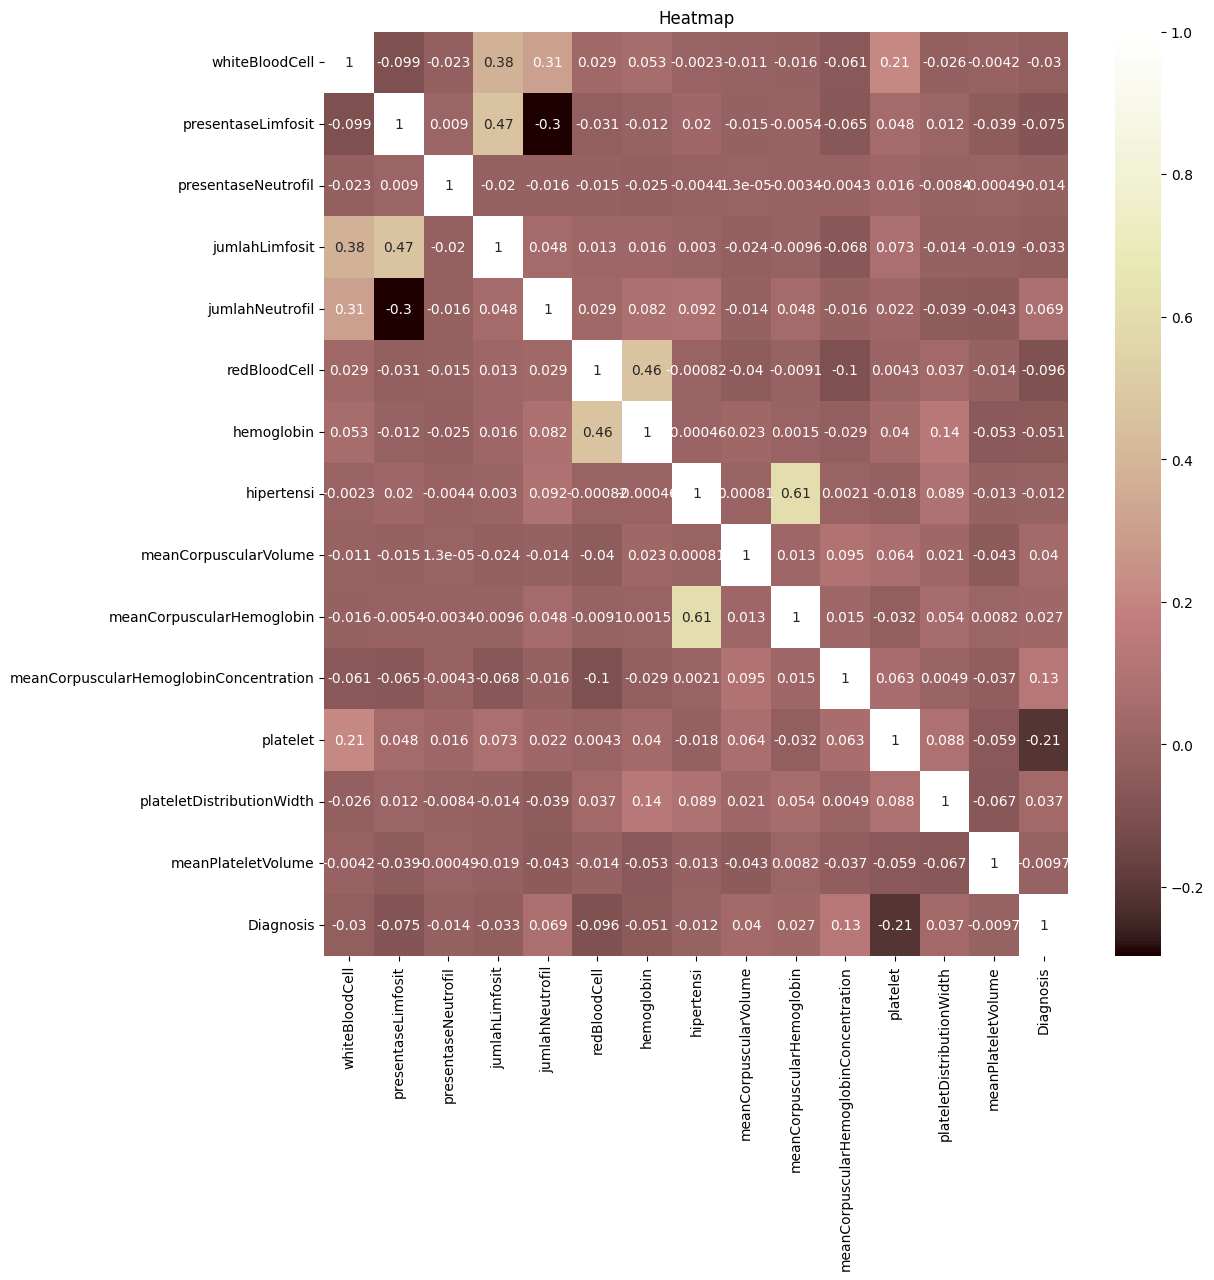

In [ ]:
plt.figure(figsize=(12, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='pink')
plt.title("Heatmap")
plt.show()

Diagnosis_mapped
Healthy                           336
Normocytic hypochromic anemia     279
Normocytic normochromic anemia    269
Iron deficiency anemia            189
Thrombocytopenia                   73
Other microcytic anemia            59
Leukemia                           47
Macrocytic Anemia                  18
Leukemia with thrombocytopenia     11
Name: count, dtype: int64


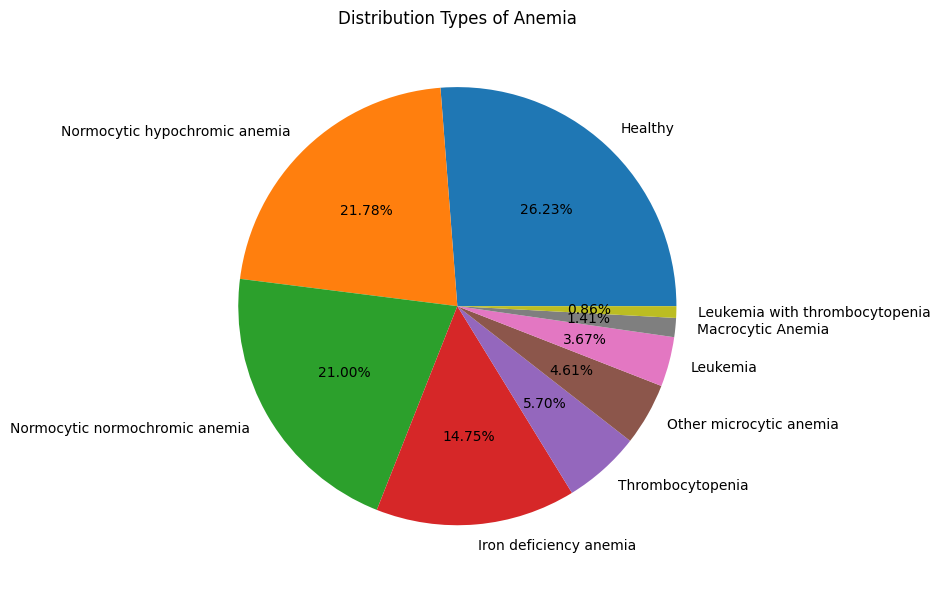

In [ ]:
anemia_type_mapping = {
    0: 'Healthy',
    1: 'Normocytic hypochromic anemia',
    2: 'Iron deficiency anemia',
    3: 'Other microcytic anemia',
    4: 'Leukemia',
    5: 'Thrombocytopenia',
    6: 'Normocytic normochromic anemia',
    7: 'Leukemia with thrombocytopenia',
    8: 'Macrocytic Anemia',
}

anemiaDataset_pd['Diagnosis_mapped'] = anemiaDataset_pd['Diagnosis'].replace(anemia_type_mapping)
anemia_counts = anemiaDataset_pd['Diagnosis_mapped'].value_counts()
print(anemia_counts)

plt.figure(figsize=(10, 6))
plt.pie(anemia_counts.values, labels=anemia_counts.index, autopct="%.2f%%")
plt.title('Distribution Types of Anemia')
plt.tight_layout()
plt.show()

meanCorpuscularVolume: 31.6%
hemoglobin: 23.97%
meanCorpuscularHemoglobinConcentration: 19.63%
whiteBloodCell: 11.82%
platelet: 8.67%
meanCorpuscularHemoglobin: 2.7%
hipertensi: 1.24%
redBloodCell: 0.38%
presentasLimfosit: 0.0%
presentaseNeutrofil: 0.0%
jumlahLimfosit: 0.0%
jumlahNeutrofil: 0.0%
plateletDistributionWidth: 0.0%
meanPlateletVolume: 0.0%


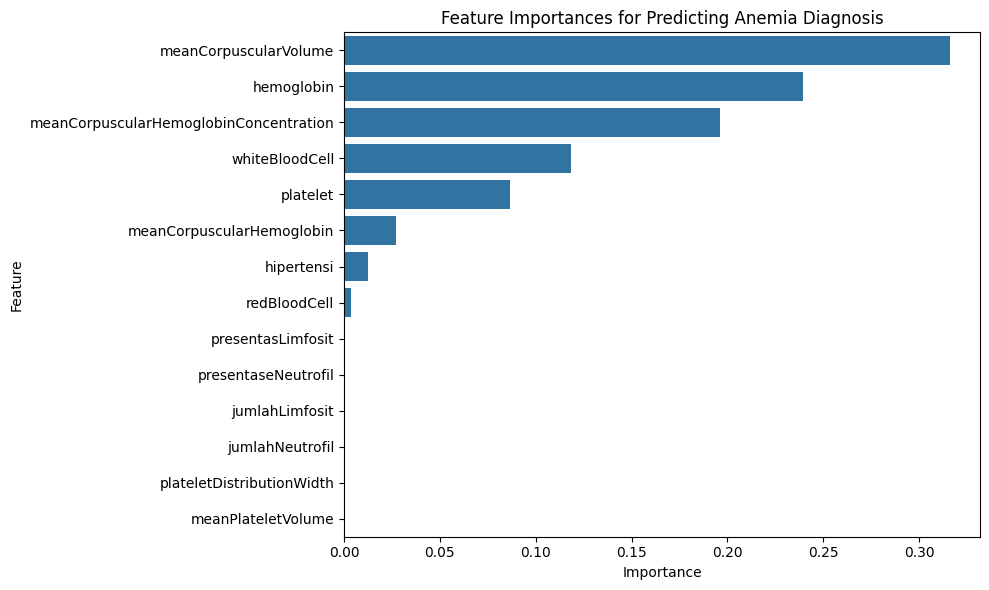

In [ ]:
importances = model.featureImportances
FeatureSelect = ["whiteBloodCell", "presentasLimfosit", "presentaseNeutrofil", "jumlahLimfosit",
                                     "jumlahNeutrofil", "redBloodCell", "hemoglobin", "hipertensi", "meanCorpuscularVolume",
                                     "meanCorpuscularHemoglobin", "meanCorpuscularHemoglobinConcentration", "platelet",
                                     "plateletDistributionWidth", "meanPlateletVolume"]
feature_importances = pd.DataFrame(importances.toArray(), index=FeatureSelect, columns=["Importance"]).sort_values(by="Importance", ascending=False)

feature_importance_dict = dict(zip(FeatureSelect, importances))
sorted_feature = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)
for feature, importance in sorted_feature:
  print(f"{feature}: {round(importance * 100, 2)}%")

plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances.Importance, y=feature_importances.index)
plt.title('Feature Importances for Predicting Anemia Diagnosis')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

##Model##

In [ ]:
# Bikin classifier Decision Tree
dt = DecisionTreeClassifier(featuresCol="scaledFeatures", labelCol="Diagnosis")

# Training model
model = dt.fit(trainingData)

# Membuat prediksi dengan testingData
predictions = model.transform(testingData)
predictions.show()

# Evaluasi model Decision Tree
evaluator = MulticlassClassificationEvaluator(labelCol="Diagnosis", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Decision Tree Accuracy: {:.2f}%".format(accuracy * 100))


+--------------+------------------+-------------------+--------------+---------------+------------+----------+----------+---------------------+-------------------------+--------------------------------------+--------+-------------------------+------------------+---------+--------------------+--------------------+--------------------+--------------------+----------+
|whiteBloodCell|presentaseLimfosit|presentaseNeutrofil|jumlahLimfosit|jumlahNeutrofil|redBloodCell|hemoglobin|hipertensi|meanCorpuscularVolume|meanCorpuscularHemoglobin|meanCorpuscularHemoglobinConcentration|platelet|plateletDistributionWidth|meanPlateletVolume|Diagnosis|            features|      scaledFeatures|       rawPrediction|         probability|prediction|
+--------------+------------------+-------------------+--------------+---------------+------------+----------+----------+---------------------+-------------------------+--------------------------------------+--------+-------------------------+------------------+--

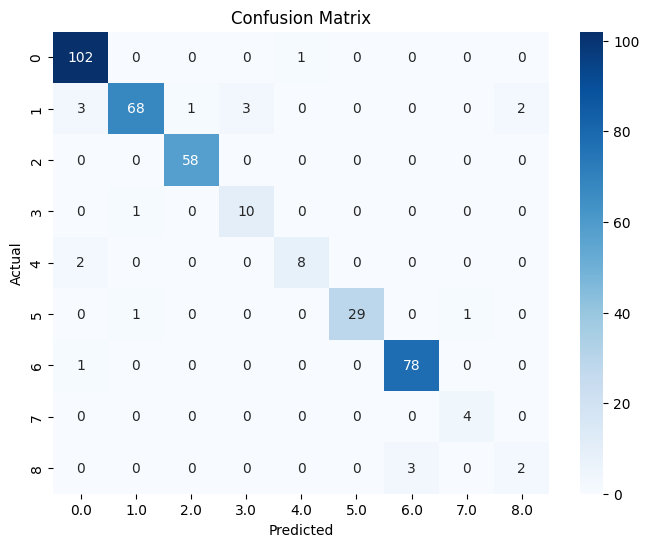

In [ ]:
conf_matrix = predictions.groupBy("Diagnosis").pivot("prediction").count().fillna(0).orderBy("Diagnosis")
conf_matrix_pd = conf_matrix.toPandas()

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_pd.iloc[:, 1:], annot=True, cmap="Blues", fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()